In [1]:
#getting the required dataset

!wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
!unzip bike+sharing+dataset.zip

--2024-08-26 20:58:23--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip’

bike+sharing+datase     [              <=>   ] 273.43K  28.1KB/s    in 9.7s    

2024-08-26 20:58:37 (28.1 KB/s) - ‘bike+sharing+dataset.zip’ saved [279992]

Archive:  bike+sharing+dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [182]:
pip install sklearn.preprocessing.TargetEncoder

ERROR: Could not find a version that satisfies the requirement sklearn.preprocessing.TargetEncoder (from versions: none)
ERROR: No matching distribution found for sklearn.preprocessing.TargetEncoder
Note: you may need to restart the kernel to use updated packages.


In [1]:
#importing the pandas lib and loading the dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_original = pd.read_csv('hour.csv')
df = df_original.copy()
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Data cleaning and validation

In [2]:
df.shape[0]

17379

In [3]:
#weekend which are not holidays are marked 0 in holiday and also 0 in workingday(1 if not workingday and not holiday)
df[df.holiday == df.workingday].weekday.value_counts() #days that are not occasions and not workingday

6    2512
0    2502
Name: weekday, dtype: int64

In [4]:
df.holiday.value_counts()[1]/df.shape[0]
#since the holydays are less number we will remove it

0.028770355026181024

In [5]:
# Convert the date column from object to datetime format
df['dteday'] = pd.to_datetime(df['dteday'])
# Extract the day from the date column
df['day'] = df['dteday'].dt.day


#droping non required columns
df.drop(['instant','dteday','casual','registered','holiday'],axis = 1,inplace = True)

#converting categorical variables into type category
df['season'] = df.season.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weathersit'] = df.weathersit.astype('category')
df['mnth'] = df.mnth.astype('category')
df['yr'] = df.yr.astype('category')
df['day'] = df.day.astype('category')
df['hr'] = df.hr.astype('category')

In [6]:
df.isna().sum().sum()

0

Therefore no null values

In [7]:
numerical_features = df.drop(['cnt'],axis = 1).select_dtypes(include='number').columns
categorical_features = df.select_dtypes(include='category').columns

In [8]:
categorical_features

Index(['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit', 'day'], dtype='object')

In [9]:
numerical_features

Index(['workingday', 'temp', 'atemp', 'hum', 'windspeed'], dtype='object')

In [10]:
df.corr()

,workingday,temp,atemp,hum,windspeed,cnt
workingday,1.000000,0.055390,0.054667,0.015688,-0.011830,0.030284
temp,0.055390,1.000000,0.987672,-0.069881,-0.023125,0.404772
atemp,0.054667,0.987672,1.000000,-0.051918,-0.062336,0.400929
hum,0.015688,-0.069881,-0.051918,1.000000,-0.290105,-0.322911
windspeed,-0.011830,-0.023125,-0.062336,-0.290105,1.000000,0.093234
cnt,0.030284,0.404772,0.400929,-0.322911,0.093234,1.000000


In [11]:
df.dtypes

season        category
yr            category
mnth          category
hr            category
weekday       category
workingday       int64
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
cnt              int64
day           category
dtype: object

In [12]:
X = df.drop(['cnt'],axis = 1)
y = df['cnt']

#data split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)

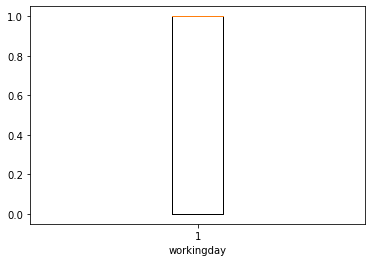

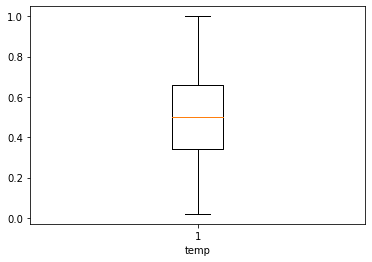

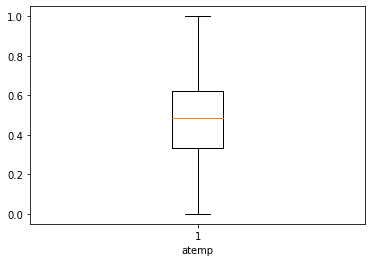

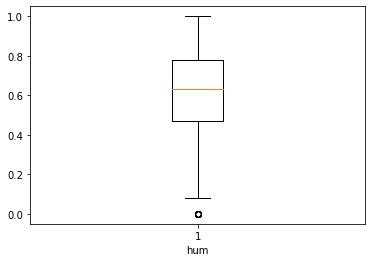

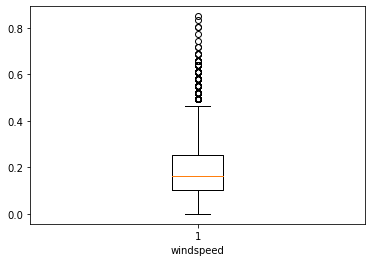

In [13]:
for var in numerical_features:
    plt.boxplot(X_train[var])
    plt.xlabel(var)
    plt.show()

we see that windspeed has outliers

In [14]:
#treating outlier using interquatrile range

def fill_outliers_with_percentile(df, column, percentile):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Calculate the specified percentile value
    percentile_value = df[column].quantile(percentile)
    # Replace outliers with the specified percentile value
    df[column] = df[column].apply(lambda x: percentile_value if x < lower_bound or x > upper_bound else x)
    
fill_outliers_with_percentile(X_train, 'windspeed',0.90)

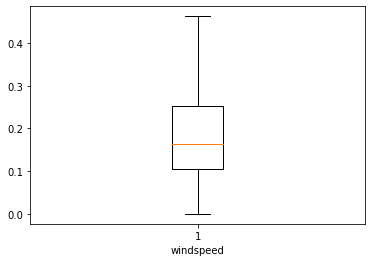

In [15]:
plt.boxplot(X_train['windspeed'])
plt.xlabel('windspeed')
plt.show()

### Feature Engineering pipeline

In [16]:
numerical_features

Index(['workingday', 'temp', 'atemp', 'hum', 'windspeed'], dtype='object')

In [17]:
X_train_dummy = X_train.copy()

In [18]:
numerical_features

Index(['workingday', 'temp', 'atemp', 'hum', 'windspeed'], dtype='object')

## Showing the importance of interacting features using selectkbest

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Numerical features
numerical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='mean')), # Impute missing values with mean
('scaler', StandardScaler()),  # Standardizes the data
('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Generates polynomial features
('select', SelectKBest(score_func=f_regression, k=8))  # Selects the top k features
])
# Transforming above
X_train_dummy[numerical_features] = numerical_pipeline.fit(X_train_dummy[numerical_features],y_train)
# Categorical features

categorical_pipeline_oh = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder( drop='first'))
])

categorical_pipeline_te = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('target_encoder', TargetEncoder())  # Encode categorical features using target encoding
])

# Transforming above
X_encoded_oh = categorical_pipeline_oh.fit_transform(X_train_dummy[categorical_features])
X_encoded_te = categorical_pipeline_te.fit_transform(X_train_dummy[categorical_features],y_train)
# Converting it to a dataframe

In [20]:
imp_feat = list(numerical_pipeline.named_steps['poly'].get_feature_names_out(numerical_features))

In [21]:
for i,b in enumerate(numerical_pipeline.named_steps['select'].get_support()):
    if not b:
        imp_feat.pop()
imp_feat

['workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'workingday^2',
 'workingday temp',
 'workingday atemp']

### We see that workingday^2, workingday\*temp ,workingday\*atemp are the important interactind features



NOW I WILL BUILD TWO COMPLETE PIPELINE USING AND USE GRID SEARCH  

## Pipeline till the model

In [44]:

#combining numerical features with categorical features
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression # Define the column transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline




def pipe(encoder_tag = 'target_encoder', encoder = TargetEncoder()):
    

    # Numerical features
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), # Impute missing values with mean
        ('scaler', StandardScaler()),  # Standardizes the data
        ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        (encoder_tag, encoder)
        ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, X_train.select_dtypes(include='number').columns),  # Apply numerical_pipeline to numerical features
            ('cat', categorical_pipeline, X_train.select_dtypes(include='category').columns)  # Apply categorical_pipeline to categorical features
        ]
    )

    # Create the final pipeline
    final_pipeline = Pipeline([
        ('preprocess', preprocessor),  # Combine the preprocessing steps
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Generates polynomial features
        ('select', SelectKBest(score_func=f_regression, k=15)),  # Selects the top k features
        ('model', LinearRegression())  # Model step
    ])


    
    return final_pipeline

In [45]:
final_pipeline_te = pipe()
final_pipeline_oh = pipe(encoder_tag = 'onehot',encoder = OneHotEncoder( drop='first'))

In [78]:
from sklearn import set_config
set_config(display= 'diagram')
final_pipeline_te

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['workingday', 'temp', 'atemp', 'hum', 'windspeed'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder())]),
                                                  Index(['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit', 'day'], dtype='object'))])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('select',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x7f81e9955ee0>)),
                ('model', LinearRegression())])

In [79]:
from sklearn import set_config
set_config(display= 'diagram')
final_pipeline_oh

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['workingday', 'temp', 'atemp', 'hum', 'windspeed'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit', 'day'], dtype='object'))])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('select',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x7f81e9955ee0>)),
                ('model', LinearRegression())])

In [59]:

grid_search_te.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['workingday', 'temp', 'atemp', 'hum', 'windspeed'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          Simple

In [68]:
import mlflow

#connecting the server in localhost
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")


In [72]:
mlflow.set_experiment("MLops Assignment")

def mlfw(X ,encoder,grid_search,r2,mse):

    with mlflow.start_run():

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", encoder)

        # Log best parameters
        mlflow.log_params(grid_search.best_params_)

        # Log model
        mlflow.sklearn.log_model(
            grid_search.best_estimator_,
            artifact_path="Grid_search",
            input_example=X,
            registered_model_name="tracking_regression",
            )




        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mse", mse)


In [81]:
param_grid = {
    'select__k' : [30,45,50,60]
}
final_pipe_te = pipe()

grid_search_te = GridSearchCV(final_pipe_te, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_te.fit(X_train, y_train)
y_pred = grid_search_te.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print("for one hot encoder")
print(f"Best Parameters: {grid_search_oh.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

mlfw(X_train ,"Target encoder",grid_search_te,r2,mse)

for one hot encoder
Best Parameters: {'select__k': 45}
Mean Squared Error: 14794.79981142752
R-squared: 0.5327772737821943


/home/sanish/myprogram/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/08/27 12:35:38 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: MlflowException("Failed to enforce schema of data '      season yr mnth  hr weekday  workingday weathersit  temp   a

2024/08/27 12:35:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run invincible-eel-909 at: http://127.0.0.1:8080/#/experiments/634179549177378349/runs/e2c8da9075f441da963457a15015449c.
2024/08/27 12:35:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/634179549177378349.


In [76]:
param_grid = {
    'select__k' : [45,50,60]
}
final_pipe_oh = pipe(encoder_tag = 'onehot',encoder = OneHotEncoder( drop='first'))

grid_search_oh = GridSearchCV(final_pipe_oh, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_oh.fit(X_train, y_train)
y_pred = grid_search_on.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print("for one hot encoder")
print(f"Best Parameters: {grid_search_oh.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

mlfw(X_train ,"onehot encoder",grid_search_oh,r2,mse)


/home/sanish/myprogram/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/home/sanish/myprogram/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/home/sanish/myprogram/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sanish/myprogram/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/sanish/myprogram/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/sanish/myprogram/lib/python3.9/sit

/home/sanish/myprogram/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/home/sanish/myprogram/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sanish/myprogram/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/sanish/myprogram/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/sanish/myprogram/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/sanish/myprogram/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", l

for one hot encoder
Best Parameters: {'select__k': 45}
Mean Squared Error: 11368.098220549116
R-squared: 0.6409931928640098


/home/sanish/myprogram/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/08/27 11:29:05 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: MlflowException("Failed to enforce schema of data '      season yr mnth  hr weekday  workingday weathersit  temp   a

2024/08/27 11:29:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run grandiose-goose-115 at: http://127.0.0.1:8080/#/experiments/634179549177378349/runs/cc40f321e3844bd5939139048f0e79ec.
2024/08/27 11:29:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/634179549177378349.
